In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import gc
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelBinarizer
import PIL
from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot
import platform

import keras
from keras import layers
from keras import metrics
from keras.models import load_model
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras import models
from keras.models import Sequential
from keras import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import VGG16
from keras.utils import plot_model

### Enable CUDA if OS is Windows

In [13]:
if platform.system() == 'Windows': 
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Set path and get all classes. ".DS_Store" needs to be removed on MacOS again

In [14]:
d = '/home/sebastian/Documents/Hauptprojekt/Daten_sorted/'
classes = (os.listdir(d))
if ".DS_Store" in classes:
    classes.remove(".DS_Store")
if "._.DS_Store" in classes:
    classes.remove("._.DS_Store")

In [15]:
print(classes)

['sales_order', 'purchase_order', 'utility_bill', 'debit_note', 'order', 'receipt', 'proforma', 'tax_invoice', 'credit_note']


In [16]:
print(tf.__version__)

NameError: name 'tf' is not defined

Global variables

In [17]:
img_size = 224
batch_size = 32
epochs = 100
mod_tax = 10
mod_order = 5
train_size = 0.7
val_size = 0.2
test_size = 0.1
seed = 4321
channels = 3
learning_rate = 0.00001

Get all Data. Because the Dataset is unbalanced we use only every 10th image of "tax_invoice" and every 5th image of "order"

In [18]:
total_set = []
total_labels = []
counter_tax = 0 
counter_order = 0

for root, dirs, files in os.walk(d):
    for file in files:
        if file.endswith(".jpg"):
            label = root.split(os.path.sep)[-1]
            if label == "tax_invoice":
                counter_tax +=1
                if counter_tax % mod_tax == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            elif label == "order":
                counter_order +=1
                if counter_order % mod_order == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            else:    
                path = os.path.join(root, file)
                total_set.append(path)
                total_labels.append(label)
            

# Return image class based on list entry (path)         
def getClass(img):
    return img.split(os.path.sep)[-2]


print(total_set[0])
print('GetClass : ', getClass(total_set[0]))
print('Label : ', total_labels[0])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/sales_order/synthetic-6a8be7d3aa8c44d6af9a2656-052(1).jpg
GetClass :  sales_order
Label :  sales_order


In [19]:
len(total_set)

19395

In [20]:
img = mpimg.imread("/home/sebastian/Documents/Hauptprojekt/Daten_sorted/debit_note/2aeea3060ec34935b5a2a6e9(2).jpg")

Plot random samples

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-60342157e5654d1292205df4-813(1).jpg


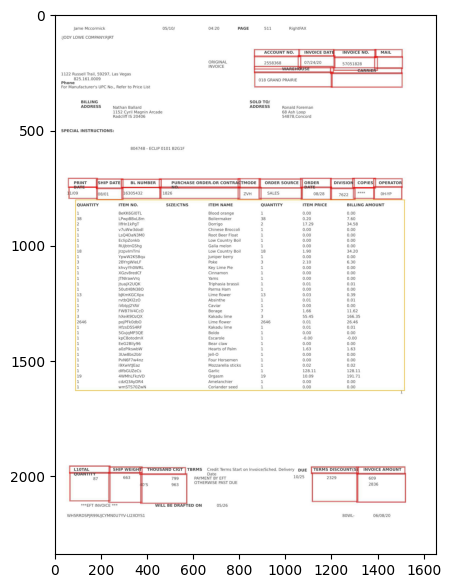

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/receipt/synthetic-410651d35003486c860e6985-120(1).jpg


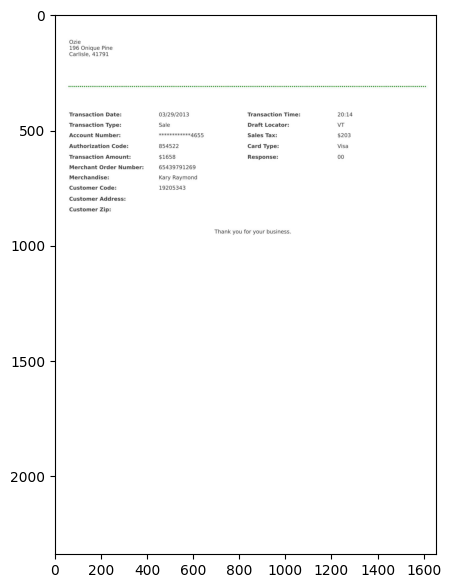

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-1c5cf2840ec745479b53bcad-958(1).jpg


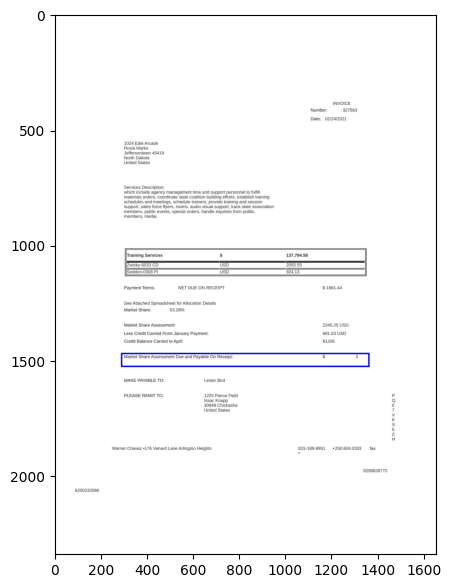

In [21]:
random.Random(seed).shuffle(total_set)

for ima in total_set[0:3] :
    print(ima)
    img = mpimg.imread(ima)
    plt.figure(figsize=(7,7))
    imgplot = plt.imshow(img, cmap="gray")
    plt.show()

Sorting the data in test, train and validation sets


In [22]:
# Get data and separate it in sets
total_len = len(total_set)
index = 0

train_set = []
train_label = []

val_set = []
val_label = []

test_set = []
test_label = []


for i in total_set[0: int(total_len*train_size)] :
    train_set.append(i)
    train_label.append(getClass(i))

    
index = int(total_len*train_size)+1
    
for i in total_set[index: int(index + total_len*val_size)] :
    val_set.append(i)
    val_label.append(getClass(i))
    
index = int(index + total_len*val_size)+1 

for i in total_set[index: total_len] :
    test_set.append(i)
    test_label.append(getClass(i))

print(train_set[750])
print(train_label[750])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-f660a970247647439670abb7-533(1).jpg
tax_invoice


Visualizing class distribution for each set

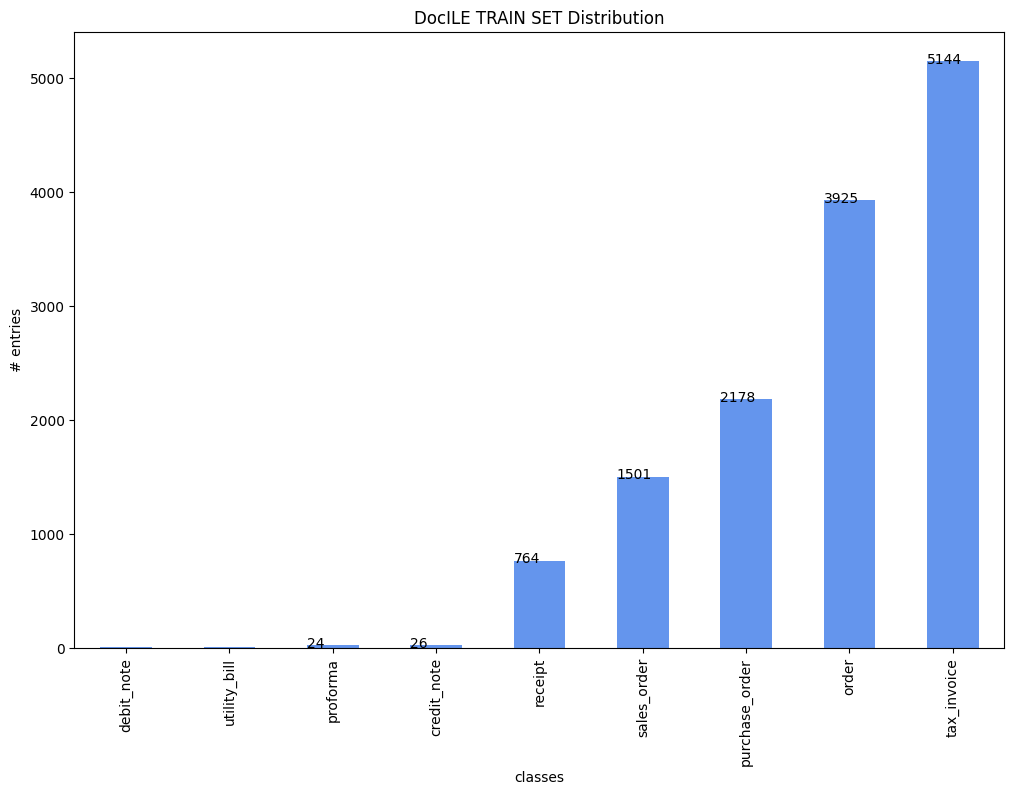

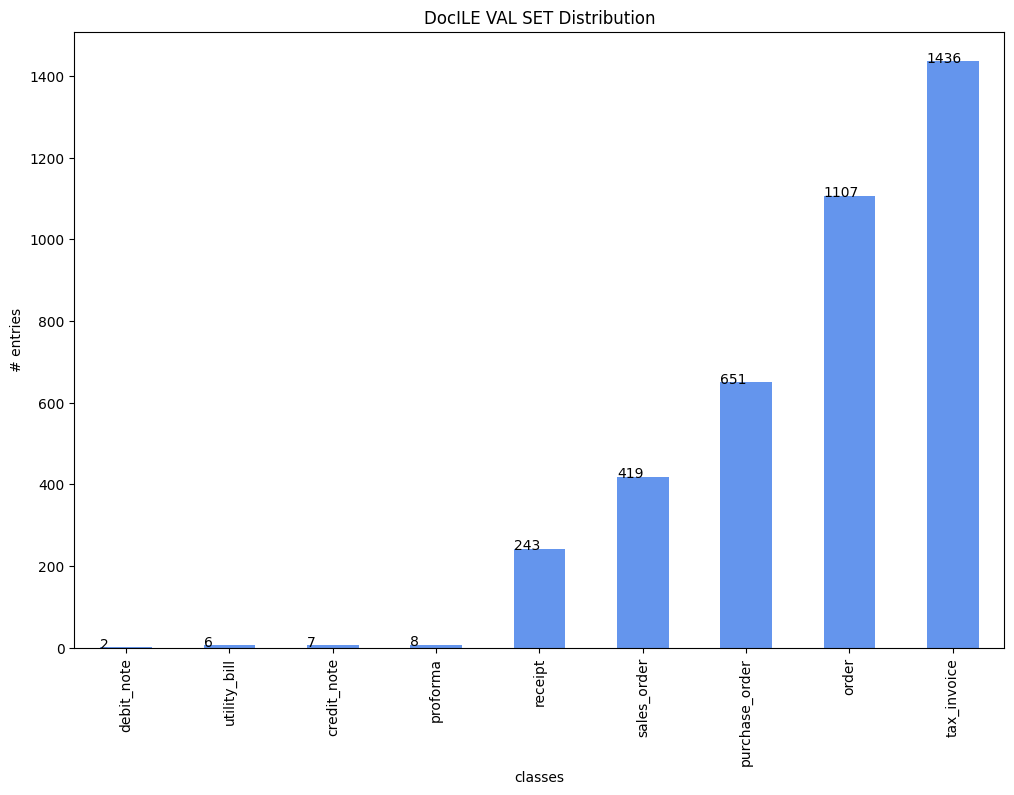

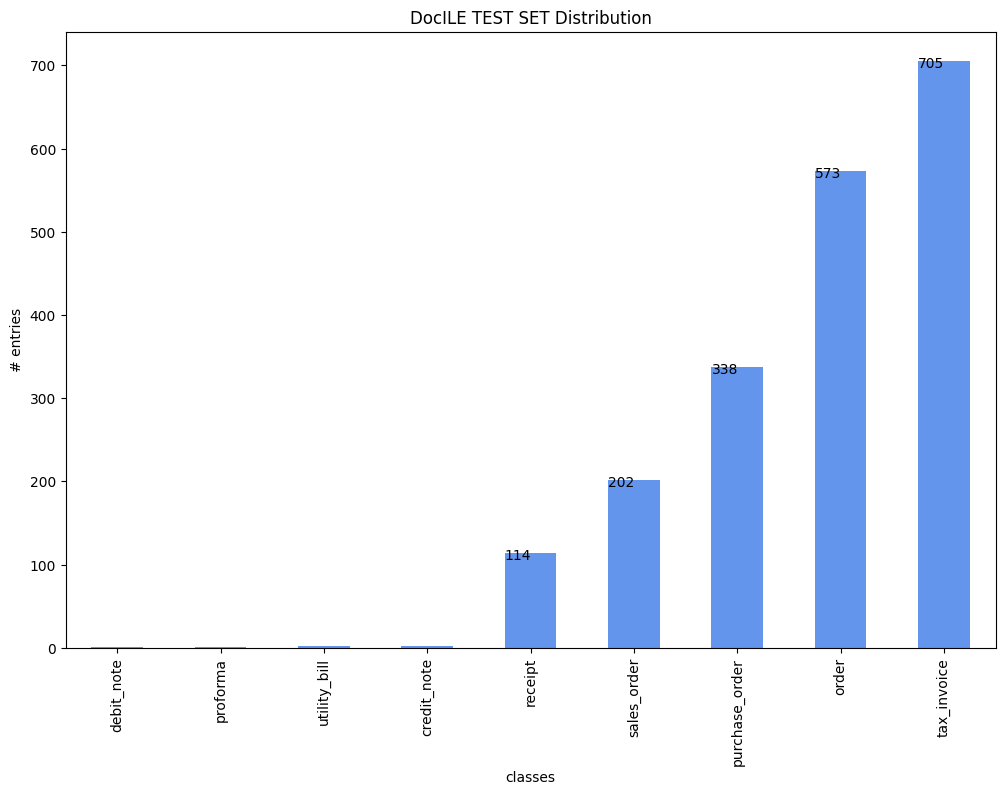

In [23]:
#################################################
# TRAIN SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in train_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TRAIN SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-20))

#################################################
# VAL SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in val_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE VAL SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-3))
    
#################################################
# TEST SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in test_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TEST SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-8))

Preprocess data (resize, transform to Numpy array and binarize)

In [114]:
def process_images(img_set) : 
    processed_img = []
    counter = 0

    for i in range(len(img_set)):
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
 
    return processed_img
    
data_train = process_images(train_set)

In [115]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
            processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))    
    
    return processed_img
    
data_test = process_images(test_set)

In [116]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
              processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
        
    return processed_img

In [117]:
test_set[200]

'/home/sebastian/Documents/Hauptprojekt/Daten_sorted/sales_order/synthetic-6a8be7d3aa8c44d6af9a2656-162(1).jpg'

use the LabelBinarizer. Documentation and functionality can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

In [12]:
lb = LabelBinarizer()
lb.fit(list(classes))

x_train = np.array(data_train)
y_train =lb.transform(np.array(train_label))

x_test = np.array(data_test)
y_test = lb.transform(np.array(test_label))

x_val = np.array(data_val)
y_val = lb.transform(np.array(val_label))

print("train images shape : ", x_train.shape)
print("train labels shape : ", y_train.shape)
print(x_train[0])

print("test shape : ", x_test.shape)
print(y_test.shape)
print("valdiation shape : ", x_val.shape)
print(y_val.shape)


for i in range(3) :
    plt.figure(figsize=(6,6))
    imgplot = plt.imshow(x_train[i])


print(train_label[0])
print(y_train[0])
print(lb.classes_)

NameError: name 'data_train' is not defined

Save the sets to .npy file for use after restarting runtime

In [123]:
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_train.npy', x_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_test.npy', x_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_train.npy', y_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_test.npy', y_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_val.npy', x_val)
np.save('//home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_val.npy', y_val)

load sets after restarting runtime

In [24]:
x_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_train.npy')
x_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_test.npy')
y_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_train.npy')
y_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_test.npy')
x_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_val.npy')
y_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_val.npy')

### Load Model

With "layer.trainable = False" you can freeze the layers of the base model. That means when your training the model that you only train the layers added to the base model. Training the whole model takes about three to four times longer for training since there are way more parameters to train.

For this project two models were testet. One with "layer.trainable = False" and one without it. 

In [51]:
base_model = VGG16(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

for layer in base_model.layers:
    layer.trainable = False
    
if layer.trainable == False:
    name_layer = "_added_layer_"
elif layer.trainable == True:
    name_layer = "_all_layer_"
    
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Create custom model

Base is VGG16, adding a flatten layer, a Dense layer and a dropout layer. Last Dense layer specify the number of classes

In [52]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu',  name='dense'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

model.summary()

print('Number of trainable weights : ', len(model.trainable_weights))

plot_model(model, to_file='model_VGG-16.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 9)                 1161      
                                                                 
Total params: 17927241 (68.39 MB)
Trainable params: 3212553 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Number 

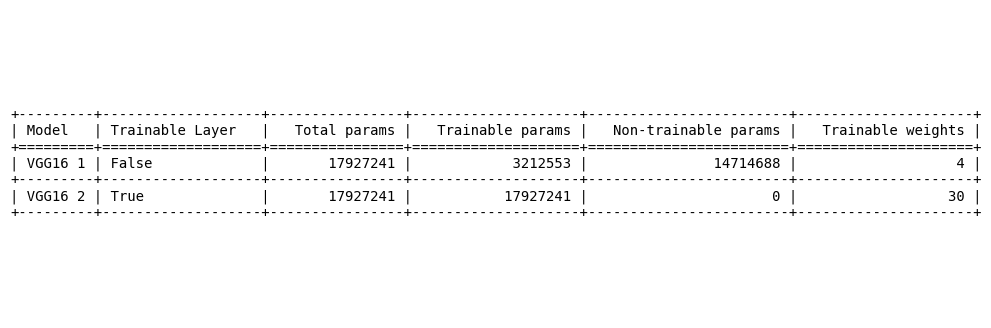

In [53]:
from tabulate import tabulate
from PIL import Image, ImageDraw, ImageFont

# Model information
model1_info = {
    "Model": "VGG16 1",
    "trainable layers": "False",
    "Total params": 17927241,
    "Trainable params": 3212553,
    "Non-trainable params": 14714688,
    "Number of trainable weights": 4
}

model2_info = {
    "Model": "VGG16 2",
    "trainable layers": "True",
    "Total params": 17927241,
    "Trainable params": 17927241,
    "Non-trainable params": 0,
    "Number of trainable weights": 30
}

# Organize model information
models_data = [
    [model1_info["Model"], model1_info["trainable layers"], model1_info["Total params"], model1_info["Trainable params"], model1_info["Non-trainable params"], model1_info["Number of trainable weights"]],
    [model2_info["Model"], model2_info["trainable layers"], model2_info["Total params"], model2_info["Trainable params"], model2_info["Non-trainable params"], model2_info["Number of trainable weights"]]
]

# Table headers
headers = ["Model", "Trainable Layer", "Total params", "Trainable params", "Non-trainable params", "Trainable weights"]

# Create and print the table
table = tabulate(models_data, headers, tablefmt="grid")


# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(8, 4))

# Remove the axes
ax.axis("off")

# Display the table text on the axis
ax.text(0.5, 0.5, table, va="center", ha="center", fontsize=10, fontfamily="monospace")

# Save the figure as an image
plt.savefig("/home/sebastian/Documents/Hauptprojekt/Models/VGG16/VGG16_table.png", bbox_inches="tight", dpi=300)


### Training the model with DocILE Data. Only the last added layers are trained

Compile : Configures the model for training.

Fit : Trains the model for a given number of epochs

https://keras.io/models/model/

In [54]:
model.compile(optimizer=optimizers.legacy.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

train_model = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val))

Epoch 1/100
425/425 [==============================] - 23s 53ms/step - loss: 4.4153 - accuracy: 0.5498 - val_loss: 0.5184 - val_accuracy: 0.8812
Epoch 2/100
425/425 [==============================] - 22s 51ms/step - loss: 0.8787 - accuracy: 0.7876 - val_loss: 0.2987 - val_accuracy: 0.9291
Epoch 3/100
425/425 [==============================] - 22s 51ms/step - loss: 0.5120 - accuracy: 0.8533 - val_loss: 0.2180 - val_accuracy: 0.9484
Epoch 4/100
425/425 [==============================] - 22s 51ms/step - loss: 0.3747 - accuracy: 0.8899 - val_loss: 0.1727 - val_accuracy: 0.9611
Epoch 5/100
425/425 [==============================] - 22s 51ms/step - loss: 0.3049 - accuracy: 0.9092 - val_loss: 0.1433 - val_accuracy: 0.9670
Epoch 6/100
425/425 [==============================] - 22s 51ms/step - loss: 0.2306 - accuracy: 0.9316 - val_loss: 0.1215 - val_accuracy: 0.9742
Epoch 7/100
425/425 [==============================] - 22s 51ms/step - loss: 0.1929 - accuracy: 0.9434 - val_loss: 0.1117 - val_ac

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)

Plot accuracy and loss of trained model

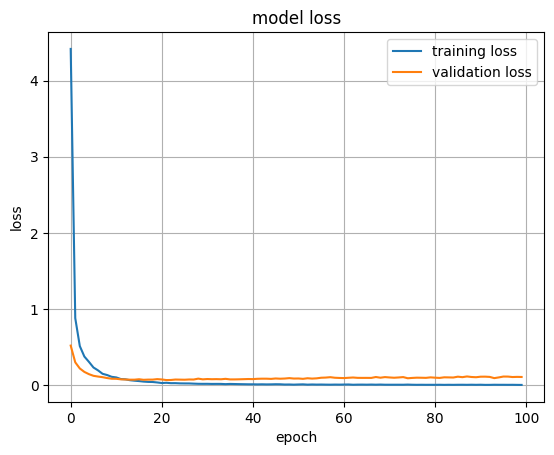

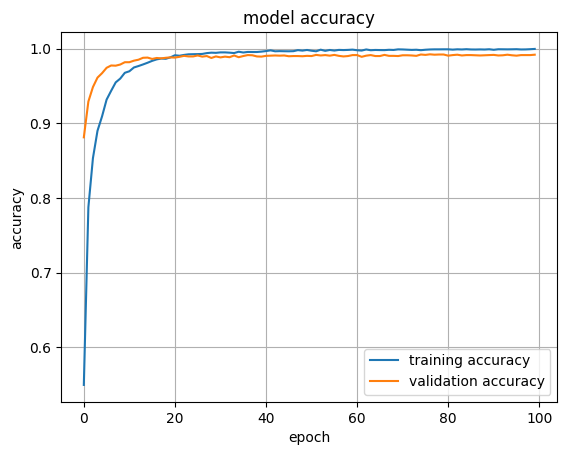

In [55]:
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/model_loss' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/model_acc' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

Test prediction accuracy on test set

In [56]:
# combine predictions + average for better score ? 

score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 2s 40ms/step - loss: 0.0799 - accuracy: 0.9902
Test loss: 0.07993817329406738
Test accuracy: 0.9901960492134094


Save Model with trained last layers

In [57]:
model.save('/home/sebastian/Documents/Hauptprojekt/Models/VGG16/trained_model' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.h5')

/home/sebastian/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Use Model on test set

In [58]:
lb = LabelBinarizer()
lb.fit(list(classes))

false_pred = []
true_pred = []

predictions=model.predict(x_test) 
predictions_list = predictions.tolist()
predicted_classes=np.argmax(predictions,axis=1)



count_true = 0
count_false = 0

for i, prediction in enumerate(predictions_list):
    print(i)
    state = True
    print(prediction)#
    print("hallo:" ,predicted_classes[i])
    if (lb.classes_[predicted_classes[i]] != test_label[i]) :
        state = False
        count_false += 1
        false_pred.append(test_label[i])
    else :
        true_pred.append(test_label[i])
        count_true += 1
    print("Prediction : ", classes[predicted_classes[i]], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))

61/61 [==============================] - 2s 35ms/step
0
[1.7141037464792282e-31, 0.0, 5.47982101594031e-23, 3.127247460977004e-35, 0.0, 2.700967757524477e-38, 2.0493105316952014e-36, 1.0, 2.005942160307158e-37]
hallo: 7
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
1
[2.3013264471155592e-12, 3.386816855069884e-14, 0.9999994039535522, 5.622053170228902e-12, 7.413046738957707e-12, 2.871429760631372e-09, 8.244510109334247e-12, 5.805744649478584e-07, 6.665916191424259e-13]
hallo: 2
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
2
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 4.4903574343357455e-26, 0.0]
hallo: 2
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
3
[7.593751585136863e-28, 3.4547852439063956e-32, 8.108105654783338e-24, 2.9714960582572033e-30, 6.247393243546847e-31, 1.4869471650218077e-29, 2.6172991097329698e-30, 1.0, 4.152172764267498e-26]
hallo: 7
Prediction :  tax_invoice    |   Real class :  ta

Prediction :  order    |   Real class :  purchase_order    |   Result :  True
433
[2.144905701547784e-23, 6.72680281417036e-25, 5.102133450972379e-13, 4.04898581913021e-18, 1.8191251018102482e-20, 6.422128493872272e-21, 1.0, 2.771021447840258e-20, 6.947792079626917e-21]
hallo: 6
Prediction :  proforma    |   Real class :  sales_order    |   Result :  True
434
[2.471116251935682e-24, 1.4283559284190827e-25, 1.0, 1.4110080816259358e-20, 4.382065530517545e-22, 4.6763770588936046e-20, 2.0542383678366597e-24, 2.525812544042921e-16, 1.1364240221166894e-25]
hallo: 2
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
435
[1.218347661256433e-13, 6.433951037400671e-20, 3.2992857090863097e-16, 6.615924211586104e-17, 1.2956013301951702e-17, 2.273194390765864e-15, 2.581018247252465e-17, 1.0, 2.0755685413352025e-17]
hallo: 7
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
436
[2.1820421175219685e-24, 9.840543865671443e-29, 1.7202699100267722e

Print wrong classifications per class

In [59]:
print(f'"debit_note" was classified wrong {false_pred.count("debit_note")} time(s) out of {false_pred.count("debit_note") + true_pred.count("debit_note")} time(s)')
print(f'"proforma" was classified wrong {false_pred.count("proforma")} time(s) out of {false_pred.count("proforma") + true_pred.count("proforma")} time(s)')
print(f'"utility_bill" was classified wrong {false_pred.count("utility_bill")} time(s) out of {false_pred.count("utility_bill") + true_pred.count("utility_bill")} time(s)')
print(f'"credit_note" was classified wrong {false_pred.count("credit_note")} time(s) out of {false_pred.count("credit_note") + true_pred.count("credit_note")} time(s)')
print(f'"receipt" was classified wrong {false_pred.count("receipt")} time(s) out of {false_pred.count("receipt") + false_pred.count("receipt")} time(s)')
print(f'"sales_order" was classified wrong {false_pred.count("sales_order")} time(s) out of {false_pred.count("sales_order") + true_pred.count("sales_order")} time(s)')
print(f'"purchase_order" was classified wrong {false_pred.count("purchase_order")} time(s) out of {false_pred.count("purchase_order") + true_pred.count("purchase_order")} time(s)')
print(f'"order" was classified wrong {false_pred.count("order")} time(s) out of {false_pred.count("order") + true_pred.count("order")} time(s)')
print(f'"tax_invoice" was classified wrong {false_pred.count("tax_invoice")} time(s) out of {false_pred.count("tax_invoice") + true_pred.count("tax_invoice")} time(s)')

"debit_note" was classified wrong 1 time(s) out of 1 time(s)
"proforma" was classified wrong 0 time(s) out of 1 time(s)
"utility_bill" was classified wrong 1 time(s) out of 2 time(s)
"credit_note" was classified wrong 1 time(s) out of 2 time(s)
"receipt" was classified wrong 6 time(s) out of 12 time(s)
"sales_order" was classified wrong 1 time(s) out of 202 time(s)
"purchase_order" was classified wrong 1 time(s) out of 338 time(s)
"order" was classified wrong 5 time(s) out of 573 time(s)
"tax_invoice" was classified wrong 3 time(s) out of 705 time(s)


create result plots

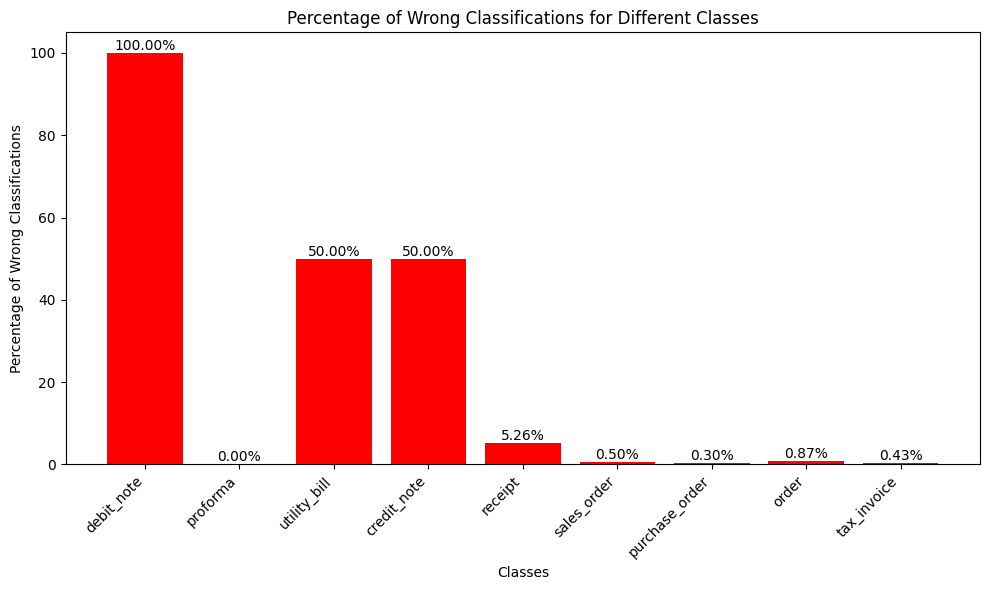

In [60]:
import matplotlib.pyplot as plt

# Data
categories = [
    "debit_note",
    "proforma",
    "utility_bill",
    "credit_note",
    "receipt",
    "sales_order",
    "purchase_order",
    "order",
    "tax_invoice"
]

wrong_counts = [
    false_pred.count("debit_note"),  # debit_note
    false_pred.count("proforma"),  # proforma
    false_pred.count("utility_bill"),  # utility_bill
    false_pred.count("credit_note"),  # credit_note
    false_pred.count("receipt"), # receipt
    false_pred.count("sales_order"),  # sales_order
    false_pred.count("purchase_order"),  # purchase_order
    false_pred.count("order"), # order
    false_pred.count("tax_invoice")  # tax_invoice
]

total_counts = [
    false_pred.count("debit_note") + true_pred.count("debit_note"),   # debit_note
    false_pred.count("proforma") + true_pred.count("proforma"),   # proforma
    false_pred.count("utility_bill") + true_pred.count("utility_bill"),   # utility_bill
    false_pred.count("credit_note") + true_pred.count("credit_note"),   # credit_note
    false_pred.count("receipt") + true_pred.count("receipt"),  # receipt
    false_pred.count("sales_order") + true_pred.count("sales_order"), # sales_order
    false_pred.count("purchase_order") + true_pred.count("purchase_order"), # purchase_order
    false_pred.count("order") + true_pred.count("order"), # order
    false_pred.count("tax_invoice") + true_pred.count("tax_invoice")  # tax_invoice
]

# Calculate percentage of wrong classifications
wrong_percentages = [wrong / total * 100 for wrong, total in zip(wrong_counts, total_counts)]
accuracy = 100 - (sum(wrong_counts) / sum(total_counts) * 100)

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, wrong_percentages, color='red')
plt.xlabel('Classes')
plt.ylabel('Percentage of Wrong Classifications')
plt.title('Percentage of Wrong Classifications for Different Classes')
plt.xticks(rotation=45, ha='right')

# Add numbers to the bars
for bar, wrong_percentage in zip(bars, wrong_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{wrong_percentage:.2f}%',
        ha='center',
        va='bottom',
        color='black',
        fontsize=10
    )

plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/WrongClassification' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = [
    "debit_note",
    "proforma",
    "utility_bill",
    "credit_note",
    "receipt",
    "sales_order",
    "purchase_order",
    "order",
    "tax_invoice"
]

wrong_counts = [
    false_pred.count("debit_note"),  # debit_note
    false_pred.count("proforma"),  # proforma
    false_pred.count("utility_bill"),  # utility_bill
    false_pred.count("credit_note"),  # credit_note
    false_pred.count("receipt"), # receipt
    false_pred.count("sales_order"),  # sales_order
    false_pred.count("purchase_order"),  # purchase_order
    false_pred.count("order"), # order
    false_pred.count("tax_invoice")  # tax_invoice
]

total_counts = [
    false_pred.count("debit_note") + true_pred.count("debit_note"),   # debit_note
    false_pred.count("proforma") + true_pred.count("proforma"),   # proforma
    false_pred.count("utility_bill") + true_pred.count("utility_bill"),   # utility_bill
    false_pred.count("credit_note") + true_pred.count("credit_note"),   # credit_note
    false_pred.count("receipt") + true_pred.count("receipt"),  # receipt
    false_pred.count("sales_order") + true_pred.count("sales_order"), # sales_order
    false_pred.count("purchase_order") + true_pred.count("purchase_order"), # purchase_order
    false_pred.count("order") + true_pred.count("order"), # order
    false_pred.count("tax_invoice") + true_pred.count("tax_invoice")  # tax_invoice
]

# Calculate percentage of wrong classifications
accuracy = 100 - (sum(wrong_counts) / sum(total_counts) * 100)

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, accuracy, color='red')
plt.xlabel('Classes')
plt.ylabel('Accuraccy')
plt.title('Accuracy for Different Classes')
plt.xticks(rotation=45, ha='right')

# Add numbers to the bars
for bar, wrong_percentage in zip(bars, wrong_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{wrong_percentage:.2f}%',
        ha='center',
        va='bottom',
        color='black',
        fontsize=10
    )

plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/Accuracy' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

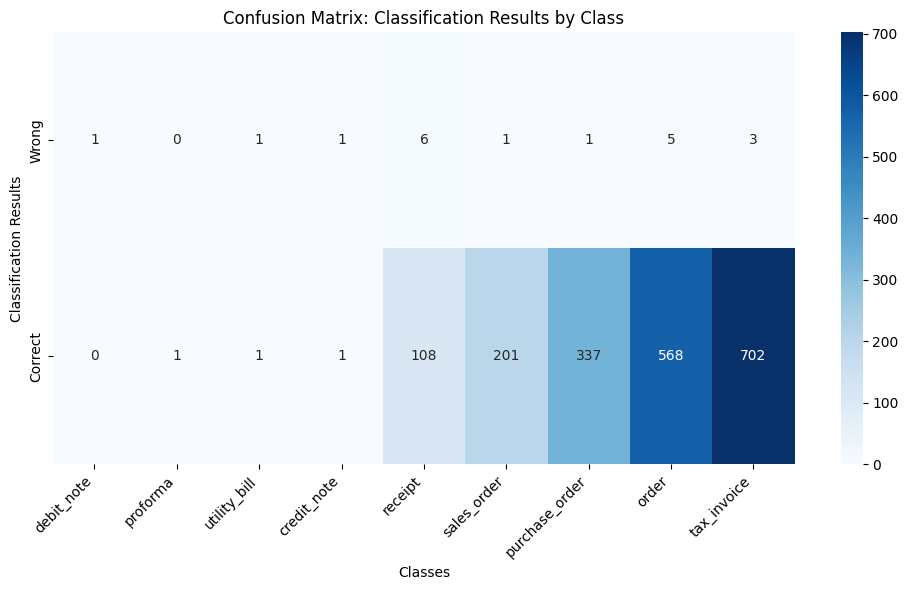

In [61]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define categories and data
categories = [
    "debit_note",
    "proforma",
    "utility_bill",
    "credit_note",
    "receipt",
    "sales_order",
    "purchase_order",
    "order",
    "tax_invoice"
]

wrong_counts = [
    false_pred.count("debit_note"),  # debit_note
    false_pred.count("proforma"),  # proforma
    false_pred.count("utility_bill"),  # utility_bill
    false_pred.count("credit_note"),  # credit_note
    false_pred.count("receipt"), # receipt
    false_pred.count("sales_order"),  # sales_order
    false_pred.count("purchase_order"),  # purchase_order
    false_pred.count("order"), # order
    false_pred.count("tax_invoice")  # tax_invoice
]
wrong_counts = np.array(wrong_counts)

total_counts = [
    false_pred.count("debit_note") + true_pred.count("debit_note"),   # debit_note
    false_pred.count("proforma") + true_pred.count("proforma"),   # proforma
    false_pred.count("utility_bill") + true_pred.count("utility_bill"),   # utility_bill
    false_pred.count("credit_note") + true_pred.count("credit_note"),   # credit_note
    false_pred.count("receipt") + true_pred.count("receipt"),  # receipt
    false_pred.count("sales_order") + true_pred.count("sales_order"), # sales_order
    false_pred.count("purchase_order") + true_pred.count("purchase_order"), # purchase_order
    false_pred.count("order") + true_pred.count("order"), # order
    false_pred.count("tax_invoice") + true_pred.count("tax_invoice")  # tax_invoice
]
total_counts = np.array(total_counts)

# Calculate percentage of wrong classifications
wrong_percentages = wrong_counts / total_counts * 100

# Create a confusion matrix
confusion_matrix = np.vstack((wrong_counts, total_counts - wrong_counts))

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=['Wrong', 'Correct'])
plt.xlabel('Classes')
plt.ylabel('Classification Results')
plt.title('Confusion Matrix: Classification Results by Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/confusion_matrix' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

In [ ]:
categories = [
    "debit_note",
    "proforma",
    "utility_bill",
    "credit_note",
    "receipt",
    "sales_order",
    "purchase_order",
    "order",
    "tax_invoice"
]

wrong_counts = [
    false_pred.count("debit_note"),  # debit_note
    false_pred.count("proforma"),  # proforma
    false_pred.count("utility_bill"),  # utility_bill
    false_pred.count("credit_note"),  # credit_note
    false_pred.count("receipt"), # receipt
    false_pred.count("sales_order"),  # sales_order
    false_pred.count("purchase_order"),  # purchase_order
    false_pred.count("order"), # order
    false_pred.count("tax_invoice")  # tax_invoice
]
wrong_counts = np.array(wrong_counts)

total_counts = [
    false_pred.count("debit_note") + true_pred.count("debit_note"),   # debit_note
    false_pred.count("proforma") + true_pred.count("proforma"),   # proforma
    false_pred.count("utility_bill") + true_pred.count("utility_bill"),   # utility_bill
    false_pred.count("credit_note") + true_pred.count("credit_note"),   # credit_note
    false_pred.count("receipt") + true_pred.count("receipt"),  # receipt
    false_pred.count("sales_order") + true_pred.count("sales_order"), # sales_order
    false_pred.count("purchase_order") + true_pred.count("purchase_order"), # purchase_order
    false_pred.count("order") + true_pred.count("order"), # order
    false_pred.count("tax_invoice") + true_pred.count("tax_invoice")  # tax_invoice
]
total_counts = np.array(total_counts)

confusion_matrix = np.column_stack((wrong_counts, total_counts - wrong_counts))
print("Confusion Matrix:")
print("\tTrue\tFalse")
for i, category in enumerate(categories):
    print(f"{category}:\t{confusion_matrix[i][1]}\t{confusion_matrix[i][0]}")